Метрики восстановления сигнала:
MSE: 0.0352
PSNR: 18.28 дБ


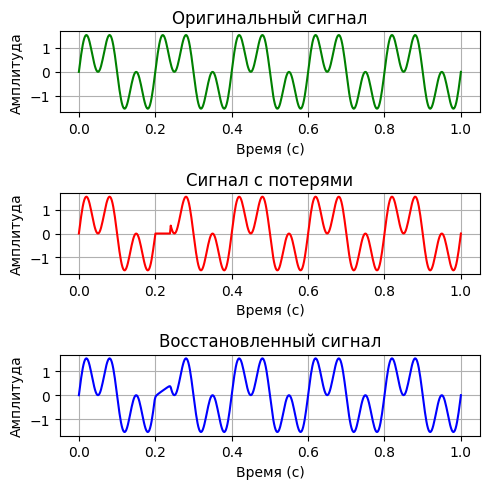

In [15]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, CubicSpline
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d, CubicSpline, PchipInterpolator, Rbf, make_interp_spline
from statsmodels.nonparametric.smoothers_lowess import lowess

# Генерация сигнала
t = np.linspace(0, 1, 500)
signal = np.sin(2 * np.pi * 5 * t) + np.sin(2 * np.pi * 15 * t)
mask = np.ones_like(signal)
mask[100:120] = 0  # Имитируем потерю фрагмента
signal_with_loss = signal * mask

# Восстановление пропущенных данных
def restore_missing_data(signal, mask, method='cubic'):
    """
    Восстанавливает пропущенные данные с помощью интерполяции.
    
    Параметры:
    - signal: сигнал с потерянными данными.
    - mask: маска пропущенных данных (1 - известные данные, 0 - пропущенные).
    - method: метод интерполяции. Может быть 'linear', 'cubic', 'pchip', 'spline', 'rbf', 'lowess', 'barycentric'.
    
    Возвращает:
    - Восстановленный сигнал.
    """
    x = np.arange(len(signal))
    known = signal[mask == 1]
    x_known = x[mask == 1]
    
    if method == 'cubic':
        interpolator = CubicSpline(x_known, known)
    elif method == 'linear':
        interpolator = interp1d(x_known, known, kind='linear', fill_value="extrapolate")
    elif method == 'pchip':
        interpolator = PchipInterpolator(x_known, known)
    elif method == 'spline':
        interpolator = make_interp_spline(x_known, known, k=3)  # Кубический сплайн
    elif method == 'rbf':
        interpolator = Rbf(x_known, known, function='multiquadric')
    elif method == 'lowess':
        # LOESS interpolation (локально-взвешенная регрессия)
        smooth_data = lowess(known, x_known, frac=0.1)
        restored_signal = np.interp(x, smooth_data[:, 0], smooth_data[:, 1])
        return restored_signal
    elif method == 'barycentric':
        interpolator = BarycentricInterpolator(x_known, known)
    else:
        raise ValueError("Неизвестный метод интерполяции. Выберите один из 'linear', 'cubic', 'pchip', 'spline', 'rbf', 'lowess', 'barycentric'.")
    
    restored_signal = interpolator(x)
    return restored_signal

# Восстанавливаем сигнал
restored_signal_cubic = restore_missing_data(signal_with_loss, mask, method='rbf')

# Вычисление метрик
mse = mean_squared_error(signal, restored_signal_cubic)
psnr = 10 * np.log10(np.max(signal)**2 / mse)

# Вывод метрик
print(f"Метрики восстановления сигнала:")
print(f"MSE: {mse:.4f}")
print(f"PSNR: {psnr:.2f} дБ")

# Вейвлет-преобразование
wavelet = 'db4'  # Новый вейвлет
level = 4  # Увеличенный уровень разложения
coeffs_original = pywt.wavedec(signal, wavelet, level=level, mode='symmetric')
coeffs_restored = pywt.wavedec(restored_signal_cubic, wavelet, level=level, mode='symmetric')

# Обратное вейвлет-преобразование для восстановленного сигнала
reconstructed_signal = pywt.waverec(coeffs_restored, wavelet)

# Построение графиков
plt.figure(figsize=(5, 5))

# График 1: Оригинальный сигнал
plt.subplot(3, 1, 1)
plt.plot(t, signal, label="Оригинальный сигнал", color='green')
plt.title("Оригинальный сигнал")
plt.xlabel("Время (с)")
plt.ylabel("Амплитуда")
plt.grid()

# График 2: Сигнал с потерями
plt.subplot(3, 1, 2)
plt.plot(t, signal_with_loss, label="Сигнал с потерями", color='red')
plt.title("Сигнал с потерями")
plt.xlabel("Время (с)")
plt.ylabel("Амплитуда")
plt.grid()

# График 3: Восстановленный сигнал
plt.subplot(3, 1, 3)
plt.plot(t, restored_signal_cubic, label="Восстановленный сигнал", color='blue')
plt.title("Восстановленный сигнал")
plt.xlabel("Время (с)")
plt.ylabel("Амплитуда")
plt.grid()

plt.tight_layout()
plt.show()
